In [1]:
import numpy as np
import pandas as pd

In [2]:
from apply_clustering import ClusteringApplier
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from numpy.random import permutation
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

def get_feature_importances(my_feature_set, df_explainable, df_observable_distances, K=100):
    feature_combinations = []
    ([[feature_combinations.append(np.array(c)) for c in combinations(np.arange(len(my_feature_set)), i)] for i in range(1, len(my_feature_set)+1)])
    
    _, df_explainable_distances = ClusteringApplier.calculate_pairwise_distances(
        df_explainable.loc[:, my_feature_set], my_feature_set, 'correlation',
    )

    X = df_explainable_distances.loc[:, my_feature_set].to_numpy()
    y = df_observable_distances.to_numpy()
    model = LinearRegression()
    model.fit(X,y)
    y_pred = model.predict(X)
    R2 = explained_variance_score(y_true=y, y_pred=y_pred)
    feature_importances = defaultdict(lambda: 0.)

    i = 0
    for cols in feature_combinations:
        for k in range(K):
            permuted_X = X.copy()
            for col_i in cols:
                permuted_X[:, col_i] = permutation(permuted_X[:, col_i])
            y_pred = model.predict(permuted_X)
            feature_importances[i] += explained_variance_score(y_true=y, y_pred=y_pred)
        i += 1

    i = 0
    for cols in feature_combinations:
        feature_importances[i] = max(0, R2 - (feature_importances[i]/K))
        i += 1
        
    adj_sum = sum(feature_importances.values())
    for key, val in feature_importances.items():
        feature_importances[key] = val / adj_sum

    assert np.isclose(sum(feature_importances.values()), 1)

    def human_readable(_dict: dict) -> dict:
        return {str([str(a) for a in np.array(my_feature_set)[feature_combinations[k]]]):v for k, v in _dict.items()}
    
    human_readable_dict = human_readable(feature_importances)
    fig_1 = plt.figure(figsize=(10, 5))
    ax1 = sns.barplot(human_readable_dict)
    ax1.axes.xaxis.set_tick_params(rotation=90)

    revised_feature_importances = defaultdict(lambda: 0)
    i = 0
    for cols in feature_combinations:
            
        a = feature_importances[i]
        b = sum([feature_importances[j] for j in cols])
        revised_feature_importances[i] += a-b#a/b-1

        i += 1

    fig_2 = plt.figure(figsize=(10, 5))
    ax2 = sns.barplot(human_readable(revised_feature_importances))
    ax2.axes.xaxis.set_tick_params(rotation=90)

    return fig_1, fig_2


In [3]:
base_size = 10000

In [4]:
observation_data = np.random.normal(loc=0, scale=1, size=(base_size, 6))

In [5]:
_a = np.random.normal(loc=0.3, scale=0.1, size=(base_size, 1)).flatten()
_b = np.random.normal(loc=0.4, scale=0.1, size=(base_size, 1)).flatten()
_c1 = np.random.normal(loc=0.5, scale=0.1, size=(base_size, 1)).flatten()
_c2 = np.random.normal(loc=0.4, scale=0.2, size=(base_size, 1)).flatten()
_d1 = np.random.normal(loc=0.3, scale=0.1, size=(base_size, 1)).flatten()
_d2 = np.random.normal(loc=0.2, scale=0.05, size=(base_size, 1)).flatten()

In [6]:
individuals = 10
explanation_data = np.random.uniform(0,1, size=(individuals, 10)) # np.random.normal(loc=0, scale=1, size=(individuals, 6))

In [7]:
df_explainable = pd.DataFrame(explanation_data)
df_explainable.loc[:, 'Individual'] = [f'Individual_{i}' for i in df_explainable.index]
df_explainable.set_index('Individual', inplace=True)
df_explainable.head()

,0,1,2,3,4,5,6,7,8,9
Individual,,,,,,,,,,
Individual_0,0.088110,0.660737,0.387810,0.060147,0.139156,0.424243,0.107182,0.591145,0.132823,0.211522
Individual_1,0.893035,0.411668,0.229860,0.383825,0.824012,0.082098,0.427890,0.829762,0.268183,0.852419
Individual_2,0.033493,0.715803,0.838972,0.359572,0.024164,0.918486,0.459062,0.189922,0.179489,0.217607
Individual_3,0.556611,0.548546,0.133517,0.115826,0.175755,0.416204,0.948341,0.765969,0.852559,0.040197
Individual_4,0.198222,0.377342,0.158198,0.968630,0.173499,0.209809,0.729877,0.620110,0.515900,0.542158


In [8]:
explaining_features = np.array(list(df_explainable.columns))

In [9]:
individual_array = np.random.choice(df_explainable.index.unique(), size=base_size)

df_observable = pd.DataFrame({
    'Individual': individual_array,
})
df_observable.loc[:, 'unexplainable_1'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_2'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_3'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_4'] = np.random.uniform(0,1, size=base_size)

req_1 = df_explainable.loc[individual_array, 1].values > 0.5
df_observable.loc[:, 'explained_by_feature_0'] = df_explainable.loc[individual_array, 0].values
df_observable.loc[:, 'explained_by_feature_1_2_3'] = req_1 * df_explainable.loc[individual_array, 2].values + (1-req_1) * df_explainable.loc[individual_array, 3].values

#np.minimum((df_explainable.loc[df_observable.loc[:, 'Individual'], 1].values > 0.5), (df_explainable.loc[df_observable.loc[:, 'Individual'], 2].values > 0.5)) * 1.0 
#(df_explainable.loc[df_observable.loc[:, 'Individual'], 1].values < 0.) * (df_explainable.loc[df_observable.loc[:, 'Individual'], 2]).values + np.random.normal(loc=0.0, scale=0.05, size=(base_size, 1)).flatten()

df_observable.set_index('Individual', inplace=True)
observed_features = list(df_observable.columns)
observed_features

['unexplainable_1',
 'unexplainable_2',
 'unexplainable_3',
 'unexplainable_4',
 'explained_by_feature_0',
 'explained_by_feature_1_2_3']

In [10]:
df_observable.head()

,unexplainable_1,unexplainable_2,unexplainable_3,unexplainable_4,explained_by_feature_0,explained_by_feature_1_2_3
Individual,,,,,,
Individual_3,0.935721,0.589479,0.697937,0.577535,0.556611,0.133517
Individual_7,0.174978,0.533474,0.878566,0.117273,0.901490,0.095228
Individual_7,0.429975,0.507894,0.534674,0.826410,0.901490,0.095228
Individual_2,0.712799,0.161617,0.488116,0.241661,0.033493,0.838972
Individual_3,0.905378,0.005941,0.321905,0.880328,0.556611,0.133517


In [11]:
df_observable = df_observable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
df_explainable = df_explainable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

In [12]:
#df_explainable.loc[:, 'Index'] = df_explainable.index
#df_observable.loc[:, 'Index'] = df_observable.index

index_name = 'Individual'

In [13]:
df_observable.shape, len(observed_features)

((10000, 6), 6)

In [80]:
my_linkage = 'single'

{'n_clusters': 14, 'knee': np.int64(6), 'elbow': np.int64(2), 'clusterer': OptimalK(n_jobs=16, parallel_backend="joblib")}


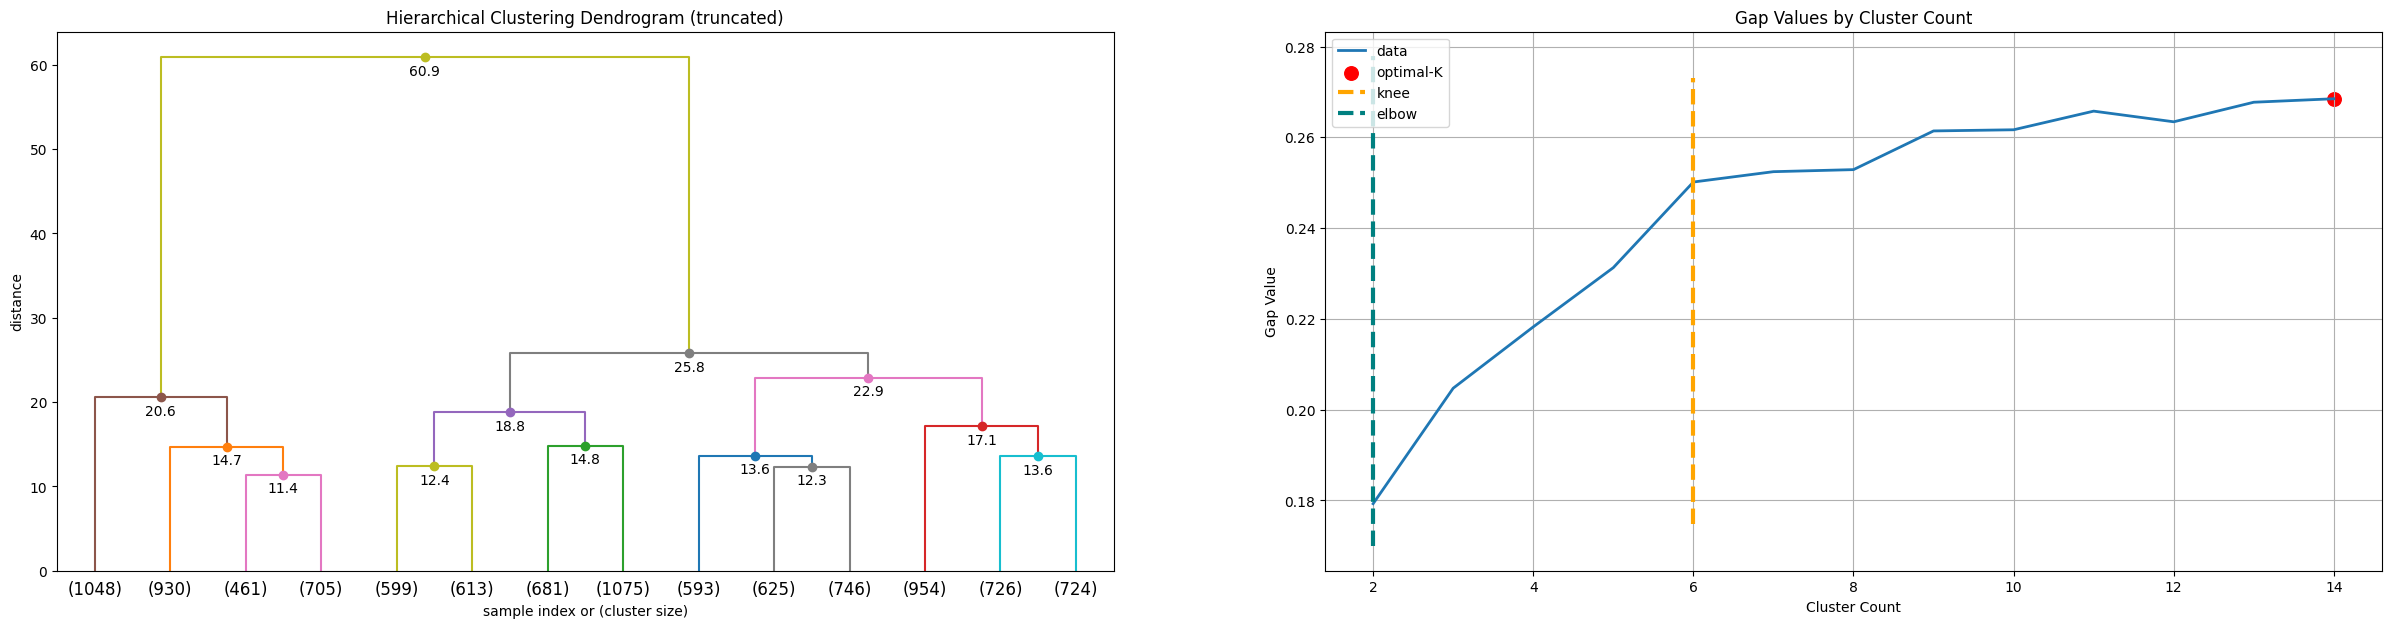

In [81]:
from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

preparation_result = DataPreparator.prepare_data(
    use_config=False,
    df_observable=df_observable.reset_index(),
    df_explainable=df_explainable.reset_index(),
    distortion_mean=0.,
    distortion_std=0.001,
    observed_features=observed_features,
    explaining_features=explaining_features,
    nn_imputation_k=10,
    group_name=index_name,
)
optimal_number_of_clusters = ClusteringApplier.draw_gap_statistic_plot(
    use_config=False, df_observable=preparation_result['observable_df'],
    observed_features=observed_features,
    gap_statistic_cluster_range=15,
    linkage='ward'
)
print(optimal_number_of_clusters)

  0%|          | 0/1013 [00:00<?, ?it/s]

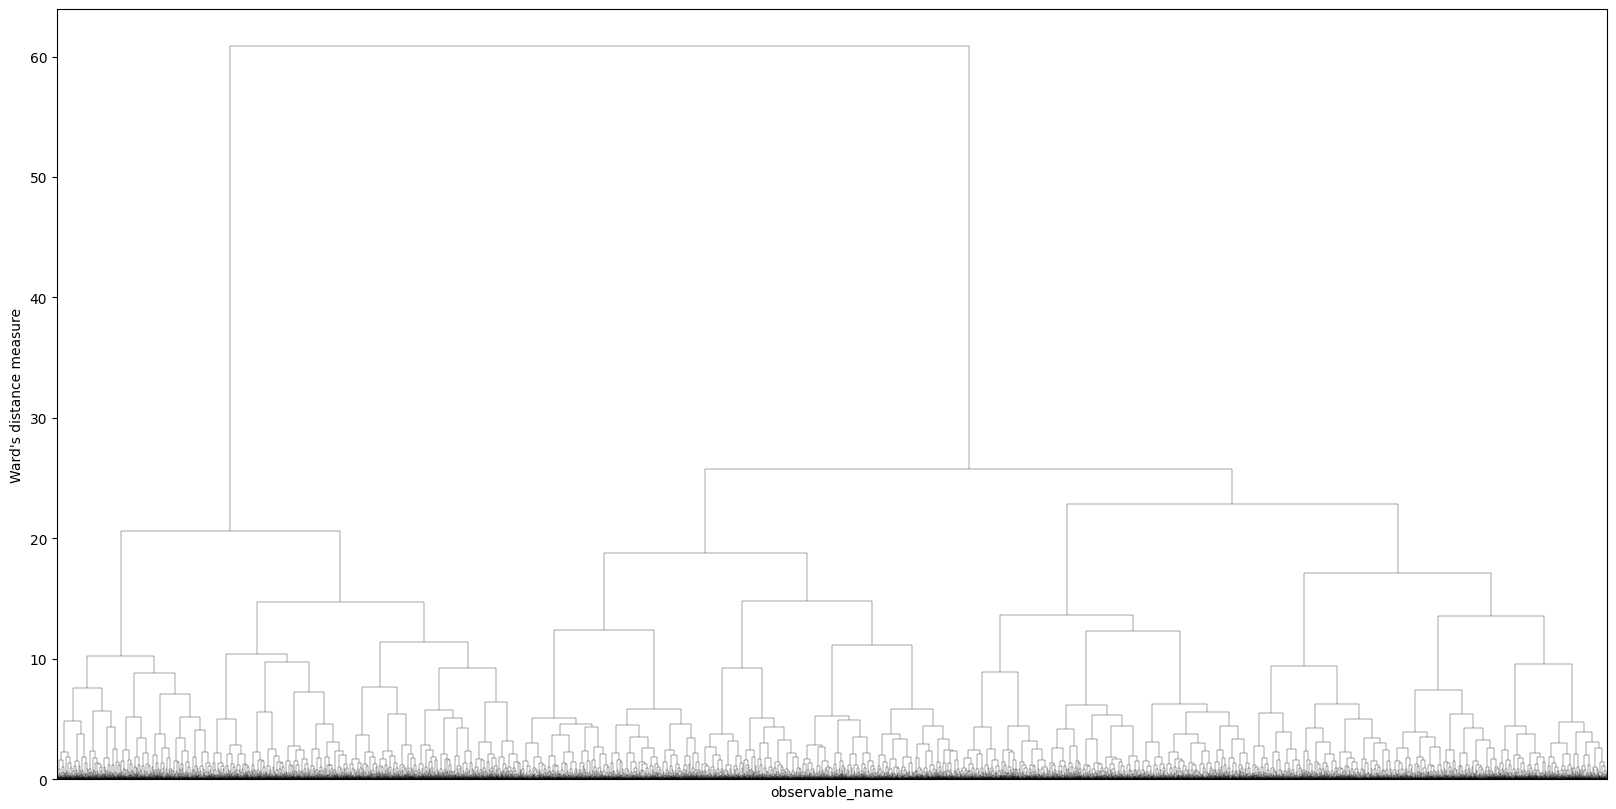

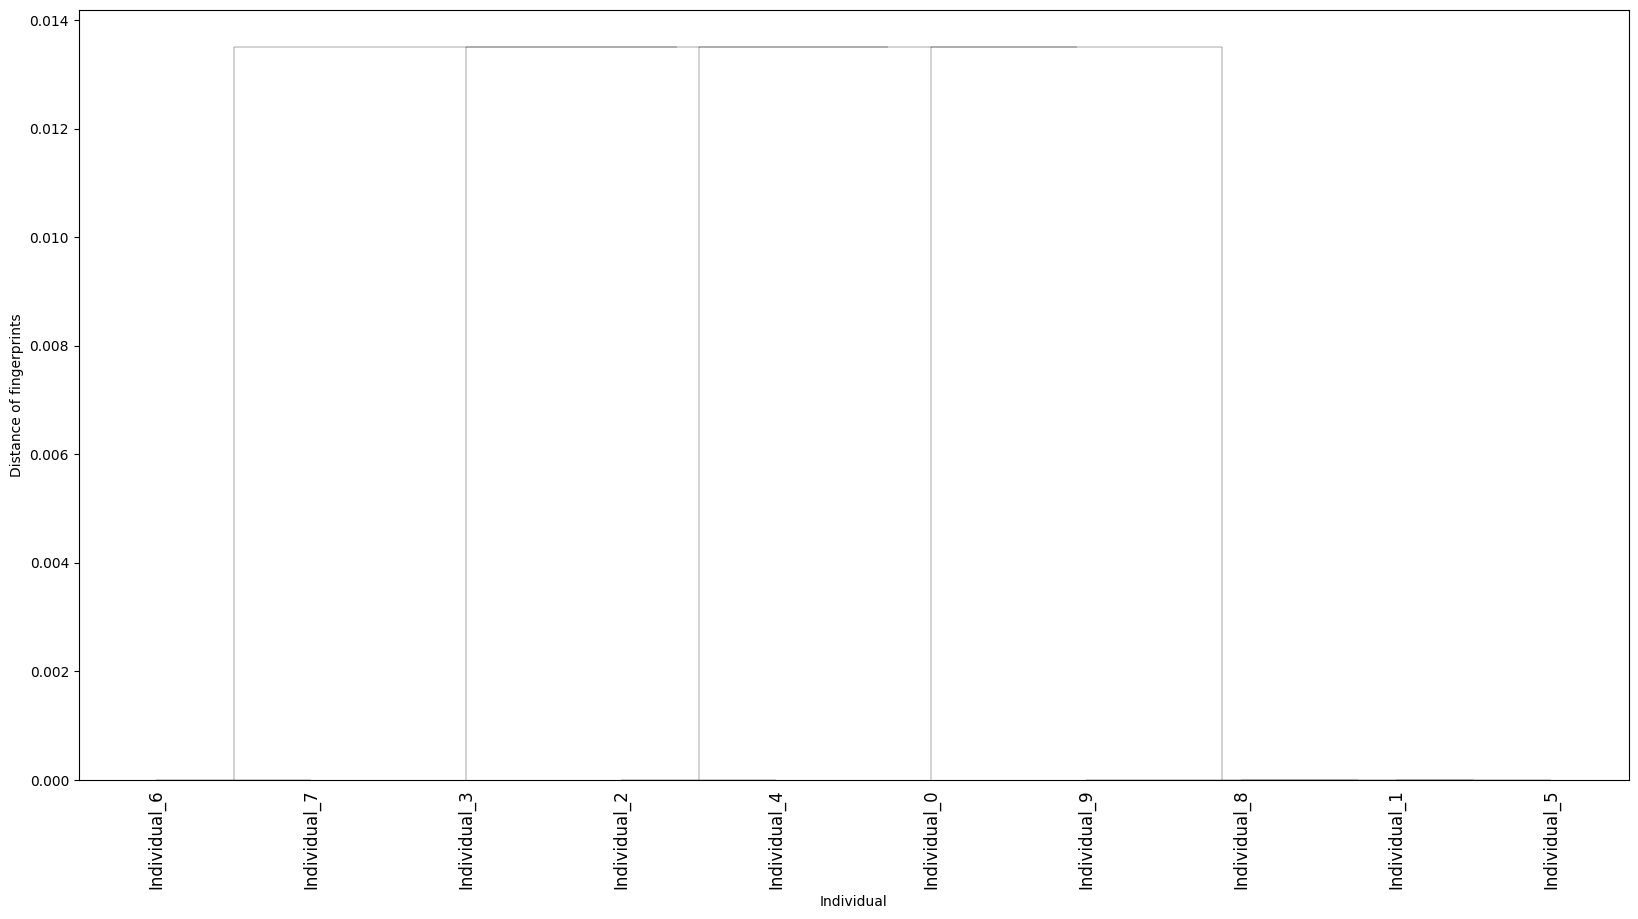

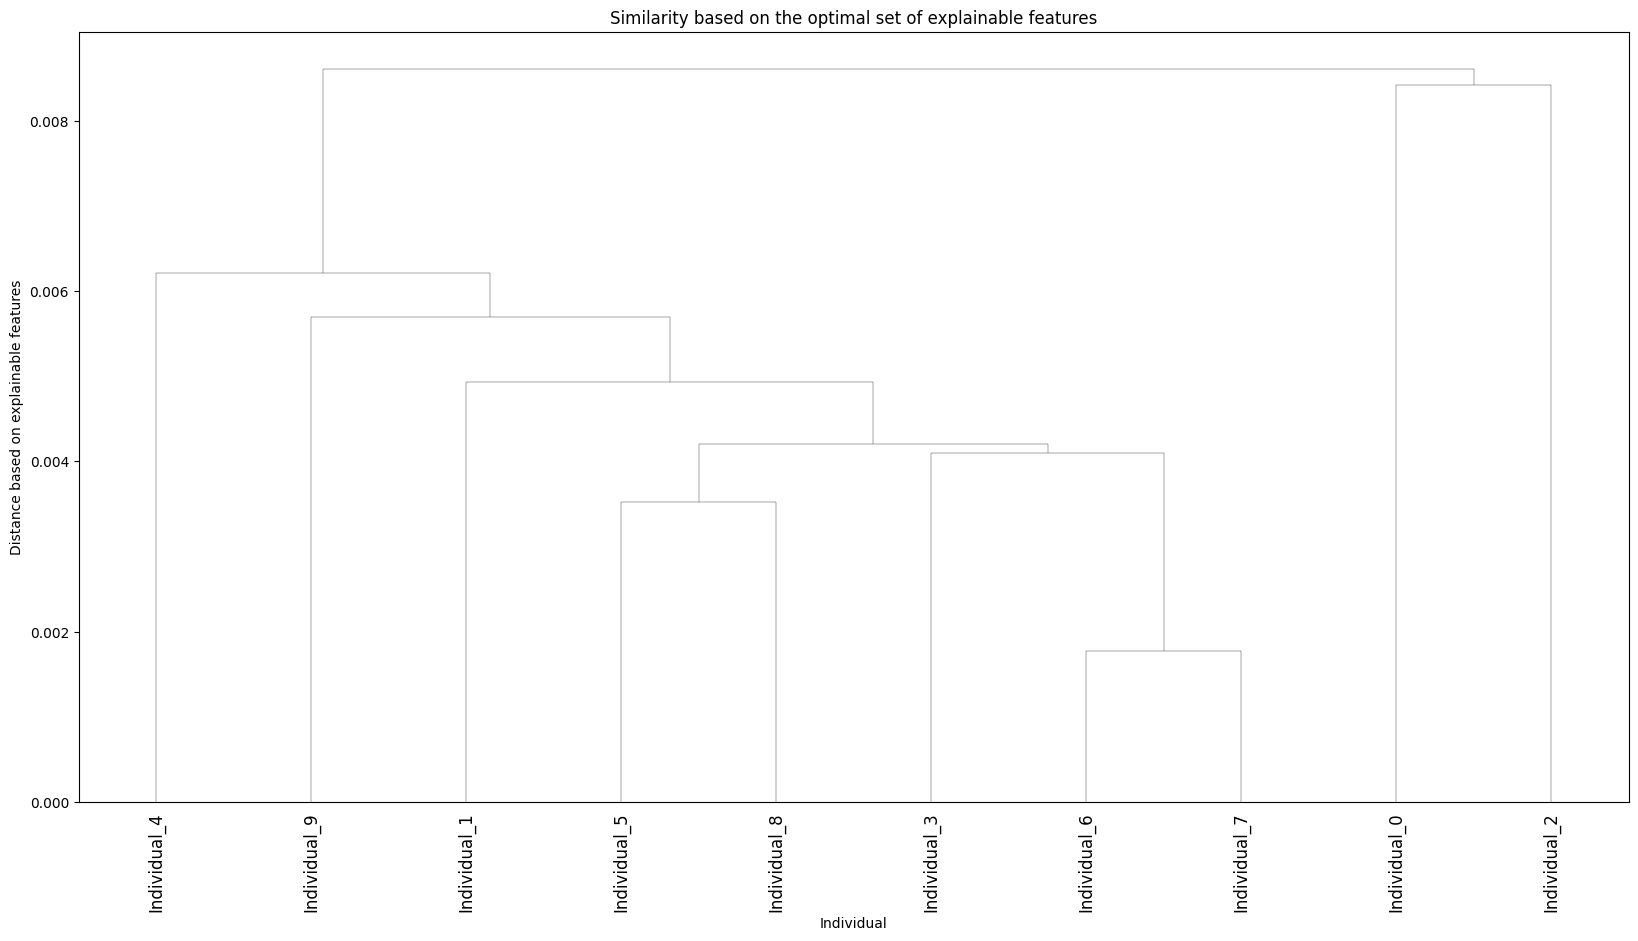

In [82]:
my_number_of_clusters = 7 #optimal_number_of_clusters['n_clusters']
observable_patterns_result = ClusteringApplier.calculate_observable_patterns(
    use_config=False,
    df_observable_data=preparation_result['observable_df'],
    _n_clusters=my_number_of_clusters,
    observable_name='observable_name',
    observable_feature_names=observed_features,
    plot_title='Name of the fingerprint plot',
    number_observable_patterns='auto',
    distance_measure_fingerprint='jensenshannon',
    group_name=index_name, 
    spiderplot_scaling='minmax',
    linkage=my_linkage
)
calculate_explainable_distances_result = ClusteringApplier.calculate_explainable_distances(
    use_config=False,
    df_explainable=preparation_result['explainable_df'].copy(),
    df_observable_distances=observable_patterns_result['pw_norm_dist'].copy(),
    explaining_features=explaining_features,
    method='exact',
    distance_measure='correlation',
    sparsity_parameter=0.01,
    max_num_threads=12,
    group_name=index_name
)

In [88]:
keystr = 'df_observable_data'

x = torch.tensor(observable_patterns_result[keystr].loc[:, observed_features].to_numpy())
y = torch.tensor(observable_patterns_result['df_cluster_median'].to_numpy())

vergleich = observable_patterns_result['df_observable_data'].pattern_type == torch.cdist(x, y).argmin(dim=1).numpy()
print(vergleich)

print(vergleich.sum() / observable_patterns_result[keystr].shape[0])

print(torch.cdist(x, y).argmin(dim=1).numpy()[:23])
print(observable_patterns_result['df_observable_data'].pattern_type[:23].to_numpy())

0       True
1       True
2       True
3       True
4       True
        ... 
9995    True
9996    True
9997    True
9998    True
9999    True
Name: pattern_type, Length: 10000, dtype: bool
0.9438
[0 2 2 1 0 4 4 1 1 1 4 4 4 4 5 4 4 2 1 4 2 2 3]
[0 2 2 1 0 4 4 1 1 1 4 4 4 4 5 4 4 2 1 4 2 2 1]


In [89]:
observable_patterns_result[keystr].loc[:, 'cluster_by_distance'] = torch.cdist(x, y).argmin(dim=1).numpy()

C:\Users\yanni\AppData\Local\Temp\ipykernel_21864\1054254932.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [94]:
observable_patterns_result[keystr].loc[~vergleich]

,Individual,unexplainable_1,unexplainable_2,unexplainable_3,unexplainable_4,explained_by_feature_0,explained_by_feature_1_2_3,oversampled,pattern_type,cluster_by_distance
22,Individual_2,0.856423,0.115950,0.774236,0.216319,0.000834,0.861794,False,1,3
25,Individual_2,0.764403,0.008513,0.040049,0.410333,0.000662,0.862962,False,1,3
26,Individual_5,0.042458,0.876956,0.779201,0.830041,0.999661,0.306308,False,4,6
36,Individual_3,0.176812,0.215552,0.990318,0.916831,0.550259,0.110206,False,0,6
75,Individual_3,0.300854,0.935548,0.914950,0.591150,0.549577,0.112302,False,0,6
...,...,...,...,...,...,...,...,...,...,...
9919,Individual_0,0.986380,0.567671,0.115674,0.298322,0.057008,0.382477,False,5,3
9936,Individual_5,0.232108,0.874810,0.853999,0.941681,0.999683,0.304818,False,4,6
9937,Individual_0,0.961768,0.045773,0.357973,0.571766,0.058781,0.381681,False,5,3
9979,Individual_0,0.843159,0.264845,0.157975,0.639556,0.056479,0.379703,False,5,3


In [84]:
observable_patterns_result['clustering_data']

,unexplainable_1,unexplainable_2,unexplainable_3,unexplainable_4,explained_by_feature_0,explained_by_feature_1_2_3
0,0.935366,0.591502,0.696185,0.578448,0.549422,0.109453
1,0.174709,0.533429,0.879479,0.118727,0.911087,0.069406
2,0.430386,0.508936,0.536036,0.825863,0.912012,0.069893
3,0.714803,0.161798,0.487749,0.241622,0.000758,0.862516
4,0.908587,0.005474,0.320567,0.880588,0.549816,0.110280
...,...,...,...,...,...,...
10475,0.827335,0.133543,0.943097,0.342618,0.703367,0.356508
10476,0.905620,0.636325,0.648656,0.403109,0.703584,0.357426
10477,0.968837,0.654712,0.162070,0.784443,0.704779,0.358365
10478,0.284573,0.717517,0.933419,0.135637,0.705414,0.357541


In [74]:
observable_patterns_result['df_observable_data']

,Individual,unexplainable_1,unexplainable_2,unexplainable_3,unexplainable_4,explained_by_feature_0,explained_by_feature_1_2_3,oversampled,pattern_type
0,Individual_3,0.933641,0.590141,0.699688,0.577835,0.549854,0.110434,False,0
1,Individual_7,0.174780,0.532964,0.877896,0.117939,0.911833,0.072418,False,4
2,Individual_7,0.430042,0.509072,0.533905,0.827599,0.909454,0.068999,False,4
3,Individual_2,0.712886,0.160756,0.488232,0.241796,0.000786,0.861843,False,1
4,Individual_3,0.905261,0.005635,0.321878,0.879221,0.546941,0.109295,False,0
...,...,...,...,...,...,...,...,...,...
9995,Individual_4,0.601123,0.978331,0.176629,0.515366,0.172925,0.998701,False,1
9996,Individual_8,0.572091,0.361069,0.009573,0.389202,0.704640,0.357119,False,2
9997,Individual_7,0.531543,0.194404,0.565790,0.504648,0.913619,0.069993,False,6
9998,Individual_8,0.334267,0.197689,0.169379,0.263668,0.704539,0.356616,False,2


In [95]:
observable_patterns_result['spider_plots']

In [19]:
preparation_result['observable_scaling']

,feature,scaling
0,unexplainable_1,1.0
1,unexplainable_2,1.0
2,unexplainable_3,1.0
3,unexplainable_4,1.0
4,explained_by_feature_0,1.0
5,explained_by_feature_1_2_3,1.0


In [20]:
calculate_explainable_distances_result.keys()

dict_keys(['overview_df', 'df_explainable_distances', 'dendrogram', 'optimal_feature_set'])

In [21]:
observable_patterns_result.keys()

dict_keys(['df_cluster_median', 'df_observable_data', 'df_fingerprint', 'pw_dist', 'pw_norm_dist', 'spider_plots', 'fingerprint_distance_plots', 'clusterer', 'clustering_data'])

In [22]:
calculate_explainable_distances_result['optimal_feature_set']

[np.int64(3), np.int64(4), np.int64(6)]

In [23]:
calculate_explainable_distances_result['overview_df']

,correlation,0,1,2,3,4,5,6,7,8,9
0,0.59482,0,0,0,1,1,0,1,0,0,0


In [24]:
df_observable_distances = observable_patterns_result['pw_norm_dist']

In [25]:
'''get_feature_importances(
    my_feature_set=calculate_explainable_distances_result['optimal_feature_set'], #explaining_features,
    df_explainable=df_explainable.reset_index(),
    df_observable_distances=df_observable_distances,
    K=100
)'''

"get_feature_importances(\n    my_feature_set=calculate_explainable_distances_result['optimal_feature_set'], #explaining_features,\n    df_explainable=df_explainable.reset_index(),\n    df_observable_distances=df_observable_distances,\n    K=100\n)"

In [26]:
...

Ellipsis

In [27]:
# Subset observable_features: endkorrelation

In [28]:
'''get_feature_importances(
    my_feature_set=explaining_features,
    df_explainable=df_explainable.reset_index(),
    df_observable_distances=df_observable_distances,
    K=100
)'''

'get_feature_importances(\n    my_feature_set=explaining_features,\n    df_explainable=df_explainable.reset_index(),\n    df_observable_distances=df_observable_distances,\n    K=100\n)'

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
def foo(df_observable, df_explainable, my_feature_set, obs_features, group_name, K=100):
    obs_df = df_observable.reset_index()
    idx = obs_df.index
    y = df_observable.reset_index().groupby(group_name).mean().to_numpy()
    
    def get_y():
        return obs_df.loc[permutation(idx)].drop_duplicates(subset=[group_name], keep='first').set_index(group_name).loc[:, obs_features].to_numpy()

    model = LinearRegression()
    #model = RandomForestRegressor(n_estimators=100, random_state=42)
    X = df_explainable.loc[:, my_feature_set].to_numpy()
    y = df_observable.reset_index().groupby(group_name).mean().loc[:, obs_features].to_numpy()
    model.fit(X,y)

    feature_importances = defaultdict(lambda: 0.)
    for col_i in range(X.shape[1]):
        for k in range(K):
            permuted_X = X.copy()
            permuted_X[:, col_i] = permutation(permuted_X[:, col_i])
            y = get_y()
            R2 = explained_variance_score(y_true=y, y_pred=model.predict(X))
            y_pred = model.predict(permuted_X)
            feature_importances[my_feature_set[col_i]] += (R2 - explained_variance_score(y_true=y, y_pred=y_pred))/K

    adj_sum = sum(feature_importances.values())
    for key, val in feature_importances.items():
        feature_importances[key] = val / adj_sum

    assert np.isclose(sum(feature_importances.values()), 1)

    return feature_importances

<Axes: >

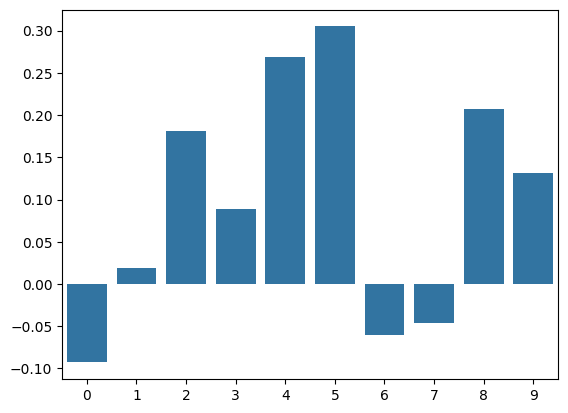

In [31]:
res = foo(preparation_result['observable_df'], preparation_result['explainable_df'], explaining_features, observed_features, group_name='Individual')
sns.barplot(res)

In [32]:
def bar(df_observable, df_explainable, my_feature_set, obs_features, group_name, K=100):
    obs_df = df_observable.reset_index()
    idx = obs_df.index
    y = df_observable.reset_index().groupby(group_name).mean().to_numpy()
    
    def get_y():
        return obs_df.loc[permutation(idx)].drop_duplicates(subset=[group_name], keep='first').set_index(group_name).loc[:, obs_features].to_numpy()

    model = LinearRegression()
    #model = RandomForestRegressor(n_estimators=300, max_depth=4)
    X = df_explainable.loc[:, my_feature_set].to_numpy()
    y = df_observable.reset_index().groupby(group_name).mean().loc[:, obs_features].to_numpy()
    model.fit(X,y)

    feature_combinations = []
    ([[feature_combinations.append(np.array(c)) for c in combinations(np.arange(len(my_feature_set)), i)] for i in range(1, len(my_feature_set)+1)])

    feature_importances = defaultdict(lambda: 0.)
    i = 0
    for cols in feature_combinations:
        for k in range(K):
            permuted_X = X.copy()
            for col_i in cols:
                permuted_X[:, col_i] = permutation(permuted_X[:, col_i])
            y = get_y()
            R2 = explained_variance_score(y_true=y, y_pred=model.predict(X))
            y_pred = model.predict(permuted_X)
            feature_importances[i] += (R2 - explained_variance_score(y_true=y, y_pred=y_pred))/K
        i += 1
    
    adj_sum = sum(feature_importances.values())
    for key, val in feature_importances.items():
        feature_importances[key] = val / adj_sum

    assert np.isclose(sum(feature_importances.values()), 1)

    def human_readable(_dict: dict) -> dict:
        return {str([str(a) for a in np.array(my_feature_set)[feature_combinations[k]]]):[v] for k, v in _dict.items()}
    
    human_readable_dict = human_readable(feature_importances)
    max(feature_importances.values())
    fig_1 = plt.figure(figsize=(10, 5))
    ax1 = sns.barplot(human_readable_dict)
    ax1.axes.xaxis.set_tick_params(rotation=90)
    plt.hlines(xmin=0, xmax=len(feature_combinations), y=max(feature_importances.values()) ,linestyles='--')

    return fig_1, feature_importances

In [33]:
import torch

In [40]:
...

Ellipsis

In [82]:
#fig, importances = bar(preparation_result['observable_df'], preparation_result['explainable_df'], explaining_features, observed_features, group_name='Individual')

In [83]:
from gradient_solver import FeatureSelectionModel
from ParameterizedModel.training import Trainer
import torch

In [92]:
df_observable_distances = observable_patterns_result['pw_norm_dist'].copy()
df_explainable = preparation_result['explainable_df'].copy()

model = FeatureSelectionModel(df_explainable.loc[:, explaining_features], df_observable_distances, penalty=0.0, num_samples=1)

# After this many steps, the learning rate is halved
HALFLIFE = 65

optimizer = torch.optim.RMSprop(
    params = [
        {'params': model.parameters['alpha'], 'lr': 0.1, 'momentum': 0.5},
        {'params': model.parameters['beta'],  'lr': 0.1, 'momentum': 0.5},
    ]
)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)

In [93]:
trainer = Trainer(model = model, optimizer = optimizer, scheduler = scheduler, dataloader = range(10))
trainer.train(epochs = 300, timeout=120)

1/300 --- Mean Loss : -0.6060651995213215
2/300 --- Mean Loss : -0.6615315432855464
3/300 --- Mean Loss : -0.6604890304092258
4/300 --- Mean Loss : -0.6637191105687942
5/300 --- Mean Loss : -0.6638211051582237
6/300 --- Mean Loss : -0.6645893395852523
7/300 --- Mean Loss : -0.6646962733841407
8/300 --- Mean Loss : -0.6642415184852336
9/300 --- Mean Loss : -0.664729406310459
10/300 --- Mean Loss : -0.6650188712681845
11/300 --- Mean Loss : -0.6641432959778432
12/300 --- Mean Loss : -0.664721758310522
13/300 --- Mean Loss : -0.6652229935165306
14/300 --- Mean Loss : -0.6650779358867208
15/300 --- Mean Loss : -0.6648065442803324
16/300 --- Mean Loss : -0.6653317524079364
17/300 --- Mean Loss : -0.6651896404781128
18/300 --- Mean Loss : -0.6658337100215709
19/300 --- Mean Loss : -0.6647730567864362
20/300 --- Mean Loss : -0.6651745479092658
21/300 --- Mean Loss : -0.6652014767768286
22/300 --- Mean Loss : -0.6658511749287457
23/300 --- Mean Loss : -0.6654792310363683
24/300 --- Mean Loss :

-0.6665575467190815


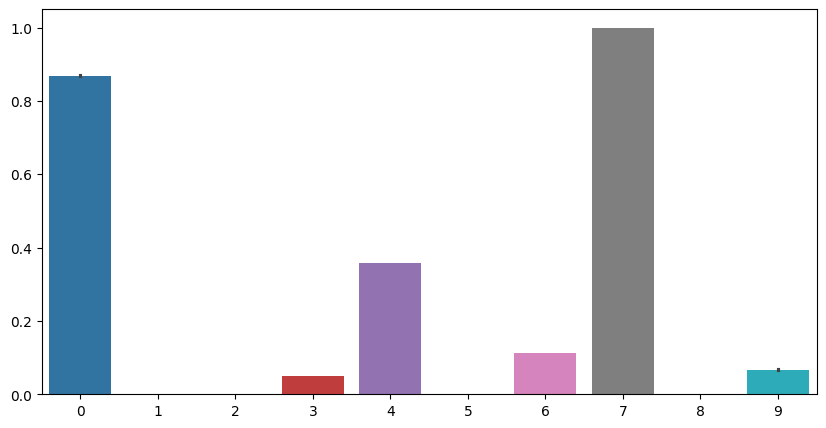

In [94]:
print(float(model.best_loss))
model.plot()

In [95]:
...

Ellipsis